<a href="https://colab.research.google.com/github/Ssurf777/VAE_sample/blob/main/modelnet10_rotation_T_net_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリインポート

In [1]:
import os
import numpy as np
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms, utils

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd

関数定義

In [2]:
import numpy as np
import plotly.graph_objs as go

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []

    def rotate_z(x, y, z, theta):
        w = x + 1j * y
        return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))

    fig = go.Figure(
        data=data,
        layout=go.Layout(
            updatemenus=[dict(
                type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(
                        frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                    )]
                )]
            )],
        ),
        frames=frames
    )
    return fig

def pcshow(xs, ys, zs):
    data = [go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(
        marker=dict(
            size=2,
            line=dict(
                width=2,
                color='DarkSlateGrey'
            )
        ),
        selector=dict(mode='markers')
    )
    fig.show()


内挿サンプリング

In [3]:
# 内挿域サンプリング
class PointSampler(object):
  def __init__(self, output_size):
    assert isinstance(output_size, int)
    self.output_size = output_size

  def triangle_area(self, pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * (side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

  def sample_point(self, pt1, pt2, pt3):
    s, t = sorted([random.random(),random.random()])
    f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
    return (f(0), f(1), f(2))

  def __call__(self,mesh):
    verts, faces = mesh
    verts = np.array(verts)
    areas = np.zeros((len(faces)))

    for i in range(len(areas)):
      areas[i] = (self.triangle_area(verts[faces[i][0]],
                                     verts[faces[i][1]],
                                     verts[faces[i][2]]))
      sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
      sampled_points = np.zeros((self.output_size,3))
    for i in range(len(sampled_faces)):
      sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                             verts[sampled_faces[i][1]],
                                             verts[sampled_faces[i][2]]))
    return sampled_points

# min-max正規化

In [4]:
class Normalize(object):
  def __call__(self, pointcloud):
    assert len(pointcloud.shape)==2

    norm_pointcloud = pointcloud - pointcloud.min()
    norm_pointcloud /= (pointcloud.max() - pointcloud.min())
    return norm_pointcloud

In [5]:
np.random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Z軸回転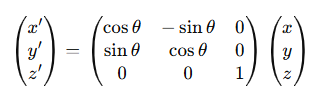

y軸回転
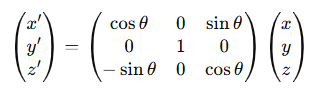

In [13]:
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,10)]

input_data_list = []

for file_name in file_names:
  with open(file_name, 'r') as f:
    verts, faces = read_off(f)

    i,j,k = np.array(faces).T
    x,y,z = np.array(verts).T

    pointcloud = PointSampler(3000)((verts,faces))

    # traindata
    train_x = pointcloud[:,0]
    train_y = pointcloud[:,1]
    train_z = pointcloud[:,2]

    # traindata rotation
    # θをランダムに生成（0から2πの範囲）
    thetaz = np.random.uniform(0, 2 * np.pi)
    # 回転行列を計算
    cos_thetaz = np.cos(thetaz)
    sin_thetaz = np.sin(thetaz)

    # z軸座標中心に回転
    train_x2 = train_x * cos_thetaz - train_y * sin_thetaz
    train_y2 = train_x * sin_thetaz + train_y * cos_thetaz
    train_z2 = train_z

    # θをランダムに生成（0から2πの範囲）
    thetay = np.random.uniform(0, 2 * np.pi)
    # 回転行列を計算
    cos_thetay = np.cos(thetay)
    sin_thetay = np.sin(thetay)

    # さらにy軸中心に回転
    train_xr = train_x2 * cos_thetay + train_z2 * sin_thetay
    train_yr = train_y2
    train_zr = -train_x2 * sin_thetay + train_z2 * cos_thetay

    # 正規化
    train_xrn = (train_xr - train_xr.min() )/ (train_xr.max() - train_xr.min())
    train_yrn = (train_yr - train_yr.min() )/ (train_yr.max() - train_yr.min())
    train_zrn = (train_zr - train_zr.min() )/ (train_zr.max() - train_zr.min())

    # data combine
    combined_data = np.concatenate((train_xrn,train_yrn,train_zrn))

    # input data
    input_data_list.append(combined_data)

  input_data = np.stack(input_data_list)
  input_tensor = torch.tensor(input_data, dtype=torch.float32).cuda()
  #input_tensor = torch.tensor(input_data, dtype=torch.float32)
  batch_size = 1
  dataset = TensorDataset(input_tensor)
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)

In [14]:
input_data.shape

(9, 9000)

形状毎に回転させた

In [15]:
pcshow(train_xrn,train_yrn,train_zrn)

T-NetをVAEのエンコーダー部分に付与

T-Net

In [16]:
# training setting
eta = 0.00001
epochs = 3000
batch_size = 1
interval = 10

In [17]:
import torch.nn.functional as F

n_in_out = 3*3000
n_mid1 = 512
n_mid2 = 256
n_mid3 = 128
n_mid4 = 64
n_mid5 = 32
n_z = 2 # 潜在変数の数

class TNETVAE(nn.Module):
  def __init__(self):
    super(TNETVAE, self).__init__()

    # T-NET Encoder
    self.conv1 = nn.Conv1d(n_in_out, 64, kernel_size = 1)
    self.conv2 = nn.Conv1d(64, 128, kernel_size = 1)
    self.conv3 = nn.Conv1d(128, 1024, kernel_size =1)
    self.linear1 = nn.Linear(1024, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 9)
    self.enc_mu = nn.Linear(9, n_z)
    self.enc_logvar = nn.Linear(9, n_z)

    # Decoder
    self.dec1 = nn.Linear(n_z, n_mid5)
    self.dec2 = nn.Linear(n_mid5, n_mid4)
    self.dec3 = nn.Linear(n_mid4, n_mid3)
    self.dec4 = nn.Linear(n_mid3, n_mid2)
    self.dec5 = nn.Linear(n_mid2, n_mid1)
    self.dec_out = nn.Linear(n_mid1, n_in_out)

    # weight initial
    self._init_weights()

  def forward(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):

    x = x.reshape(1, n_in_out, 1)
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(x.size(0), -1)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    mu = self.enc_mu(x)
    logvar = self.enc_logvar(x)
    std = torch.exp(0.5 * logvar) # sigma
    eps = torch.randn_like(std) # 正規分布に従う乱数
    z = mu +std * eps # 潜在変数
    self.mu = mu
    self.logvar = logvar
    return mu, logvar

  def decode(self,z):
    z_sample = z[0]
    x = F.relu(self.dec1(z_sample))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    x = F.relu(self.dec5(x))
    x = torch.sigmoid(self.dec_out(x))
    return x

  def loss(self, y, x):
    x = x.view(-1, n_in_out)

    rec_loss = F.mse_loss(y, x, reduction="sum") # 再構成誤差をMSEで計算
    reg_loss = 0.5 * torch.sum(self.mu**2 + torch.exp(self.logvar) - self.logvar -1 ) # 正則化項
    return (rec_loss, reg_loss)

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

vae = TNETVAE()
print(vae)
vae.cuda()




TNETVAE(
  (conv1): Conv1d(9000, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=9, bias=True)
  (enc_mu): Linear(in_features=9, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=9, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=9000, bias=True)
)


TNETVAE(
  (conv1): Conv1d(9000, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=9, bias=True)
  (enc_mu): Linear(in_features=9, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=9, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=9000, bias=True)
)

In [18]:
from torch import optim

optimizer = optim.Adam(vae.parameters(),lr=eta)

rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x,) in enumerate(data_loader):
    x = x.cuda()
    y = vae(x)
    lrec, lreg = vae.loss(y,x)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total/= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)
  if i%interval ==0:
    print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

Epoch:0 Loss_Rec:512.8513556586372 Loss_Reg:0.0012067092789544 Loss_Total:512.8525729709202
Epoch:10 Loss_Rec:511.2865397135417 Loss_Reg:0.6363602744208442 Loss_Total:511.92290581597223
Epoch:20 Loss_Rec:499.782233344184 Loss_Reg:5.062980280982123 Loss_Total:504.84521145290796
Epoch:30 Loss_Rec:480.1189948187934 Loss_Reg:9.534529209136963 Loss_Total:489.65352037217883
Epoch:40 Loss_Rec:468.5172831217448 Loss_Reg:9.157370302412245 Loss_Total:477.67464870876734
Epoch:50 Loss_Rec:462.8690999348958 Loss_Reg:7.667599148220486 Loss_Total:470.5366956922743
Epoch:60 Loss_Rec:459.38529798719617 Loss_Reg:6.469115495681763 Loss_Total:465.85441419813367
Epoch:70 Loss_Rec:457.0030517578125 Loss_Reg:5.5805098215738935 Loss_Total:462.5835605197483
Epoch:80 Loss_Rec:454.9327969021267 Loss_Reg:5.025943875312805 Loss_Total:459.958733452691
Epoch:90 Loss_Rec:453.02952745225696 Loss_Reg:4.632107403543261 Loss_Total:457.66163126627606
Epoch:100 Loss_Rec:451.2678731282552 Loss_Reg:4.3355023463567095 Loss_To

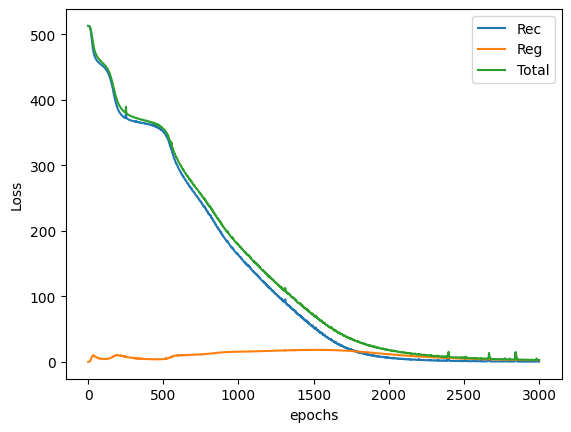

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(rec_error_record)+1),rec_error_record,label="Rec")
plt.plot(range(1, len(reg_error_record)+1),reg_error_record,label="Reg")
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()


# 再構成して可視化する

In [20]:
vae.eval()
with torch.no_grad():
  reconstructions = []
  for batch in data_loader:
    batch = batch[0]
    recon_batch = vae(batch)
    reconstructions.append(recon_batch.cpu().numpy())

reconstructed_data = recon_batch.cpu().detach().numpy().reshape(-1)

reconstructed_x = reconstructed_data[:3000]
reconstructed_y = reconstructed_data[3000:6000]
reconstructed_z = reconstructed_data[6000:9000]


In [21]:
print("Original")
pcshow(train_xrn,train_yrn,train_zrn)
print("再構成")
pcshow(reconstructed_x,reconstructed_y,reconstructed_z)

Original


再構成


In [31]:
# 潜在変数を振って可視化する
z_mod = torch.tensor([[-0.8,-0.83]],device='cuda:0')
recon_batch2 = vae.decode(z_mod)
reconst2= recon_batch2.cpu().detach().numpy().reshape(-1)

reconst2_x = reconst2[:3000]
reconst2_y = reconst2[3000:6000]
reconst2_z = reconst2[6000:9000]
pcshow(reconst2_x,reconst2_y,reconst2_z)

In [ ]:
import torch
'''
# ループして潜在変数を変化させ、再構築と可視化を行う
for z1 in np.arange(-1.0, 1.5, 0.5):
    for z2 in np.arange(-1.0, 1.5, 0.5):
        z_mod = torch.tensor([[z1, z2]], device='cuda:0', dtype=torch.float32)
        recon_batch2 = vae.decode(z_mod)
        reconst2 = recon_batch2.cpu().detach().numpy().reshape(-1)

        reconst2_x = reconst2[:3000]
        reconst2_y = reconst2[3000:6000]
        reconst2_z = reconst2[6000:9000]

        print(f"Visualizing for z1={z1}, z2={z2}")
        pcshow(reconst2_x, reconst2_y, reconst2_z)
'''

In [ ]:
def plot_point_cloud(xs, ys, zs, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=1)
    ax.set_title(title)
    plt.show()


In [ ]:
# ループして潜在変数を変化させ、再構築と可視化を行う
for z1 in np.arange(-1.0, 1.2, 0.2):
    for z2 in np.arange(-1.0, 1.2, 0.2):
        z_mod = torch.tensor([[z1, z2]], device='cuda:0', dtype=torch.float32)  # データ型をfloat32に設定
        recon_batch2 = vae.decode(z_mod)
        reconst2 = recon_batch2.cpu().detach().numpy().reshape(-1)

        reconst2_x = reconst2[:3000]
        reconst2_y = reconst2[3000:6000]
        reconst2_z = reconst2[6000:9000]

        title = f"Point Cloud for z1={z1}, z2={z2}"
        plot_point_cloud(reconst2_x, reconst2_y, reconst2_z, title)
